In [1]:
from core import download_IC

Data downloaded successfully


In [2]:
from core import readfiles
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep
from numba import jit, njit, prange
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
import bisect

read icdata
read uptdata
read eadata
read mspdata


In [3]:
all_enu = np.logspace(11.001, 18.999, 1000)
gamma_arr = [-1, -2.2, -2.5, -3]
phi0m = [1e-49, 1e-44, 1e-43, 1e-43]

#Compute the background PDF for all neutrinos as per eqn 9 of 2205.15963
#and store them at /data/all_Bi.dat


all_Bi = signals(4).compute_background()
all_Bi.tofile(os.getcwd() + 'data/all_Bi.dat', sep=',')

In [4]:
all_Bi = np.loadtxt(os.getcwd() + '/data/all_Bi.dat', delimiter=',')

In [5]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963
all_Si = np.asfarray([signals(gamma_arr[i]).compute_signal() for i in tqdm(prange(4))])

100%|██████████| 4/4 [01:30<00:00, 22.60s/it]


In [6]:
e_nu_wall

array([1.00000000e+11, 1.58489319e+11, 2.51188643e+11, 3.98107171e+11,
       6.30957344e+11, 1.00000000e+12, 1.58489319e+12, 2.51188643e+12,
       3.98107171e+12, 6.30957344e+12, 1.00000000e+13, 1.58489319e+13,
       2.51188643e+13, 3.98107171e+13, 6.30957344e+13, 1.00000000e+14,
       1.58489319e+14, 2.51188643e+14, 3.98107171e+14, 6.30957344e+14,
       1.00000000e+15, 1.58489319e+15, 2.51188643e+15, 3.98107171e+15,
       6.30957344e+15, 1.00000000e+16, 1.58489319e+16, 2.51188643e+16,
       3.98107171e+16, 6.30957344e+16, 1.00000000e+17, 1.58489319e+17,
       2.51188643e+17, 3.98107171e+17, 6.30957344e+17, 1.00000000e+18,
       1.58489319e+18, 2.51188643e+18, 3.98107171e+18, 6.30957344e+18,
       1.00000000e+19])

In [7]:
e_nu

array([1.29244660e+11, 2.04838981e+11, 3.24647907e+11, 5.14532258e+11,
       8.15478672e+11, 1.29244660e+12, 2.04838981e+12, 3.24647907e+12,
       5.14532258e+12, 8.15478672e+12, 1.29244660e+13, 2.04838981e+13,
       3.24647907e+13, 5.14532258e+13, 8.15478672e+13, 1.29244660e+14,
       2.04838981e+14, 3.24647907e+14, 5.14532258e+14, 8.15478672e+14,
       1.29244660e+15, 2.04838981e+15, 3.24647907e+15, 5.14532258e+15,
       8.15478672e+15, 1.29244660e+16, 2.04838981e+16, 3.24647907e+16,
       5.14532258e+16, 8.15478672e+16, 1.29244660e+17, 2.04838981e+17,
       3.24647907e+17, 5.14532258e+17, 8.15478672e+17, 1.29244660e+18,
       2.04838981e+18, 3.24647907e+18, 5.14532258e+18, 8.15478672e+18])

In [8]:
#For each energy, find ns for all pulsars summed over all seasons and sum ns over all pulsars for each energy
#FIND ns^ as in eqn 3 of 2205.15963


#use np.digitize for binary search for BETTER READABILITY


@njit(fastmath=True)
def ns_singleseason_sing_psr_HAT(dec,enu, gamma, phi0 = 1e-40, season=0):
    '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


    tt_upt = t_upt[season]
    if enu <= 1e11 or enu >= 1e19:
        return 0.0
    else:
        k=0
        l=0
        for i in range(0, len(e_nu_wall)):
            if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
                for j in range(0, len(dec_nu)):
                    if dec_nu[j] <= dec and dec_nu[j+1] > dec:
                        k=i
                        l=j
                        break
                break

        temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
        return tt_upt * (enu**2) * temp_ea * dfde(enu, gamma, phi0)


In [9]:
#For each energy, find ns for all pulsars summed over all seasons and sum ns over all pulsars for each energy
#FIND TS as in eqn 3 of 2205.15963

#28032023 SD suggestion - USE trapz

all_TSS = []
nss_all_gamma = []
for gamma in prange(4):
    nss_all_eng = []
    for enu in prange(len(all_enu)):
        psrns = 0
        for psrdec in prange(p):
            for season in range(10):    
                psrns += ns_singleseason_sing_psr_HAT(msdec[psrdec], all_enu[enu], gamma_arr[gamma], phi0m[gamma],season=season)
                # nss.append(ns_singleseason_sing_psr_HAT(psrdec, all_enu[enu], gamma_arr[gamma], season=season))
        nss_all_eng.append(psrns)
    
    @njit
    def TS_for_all_psrs2(nsa):
        return Ts_arr2(nsa, all_Si[gamma], all_Bi, Ns)

    pool = mul.Pool(12, maxtasksperchild=200)
    op_arr = pool.map_async(TS_for_all_psrs2, nss_all_eng)
    temp = op_arr.get()
    pool = []
    op_arr = []
    all_TSS.append(temp)

    # nss_all_gamma.append(nss_all_eng)

In [10]:
for i in range(4):
    print(min(all_TSS[i]), max(all_TSS[i]))

-15.042473151844854 8.09778910593195e-11
-18.762637806468923 -5.908138414647721e-06
-29.83771605162602 -0.00026870734126161714
-13.955738615147855 -6.774200293071686e-05


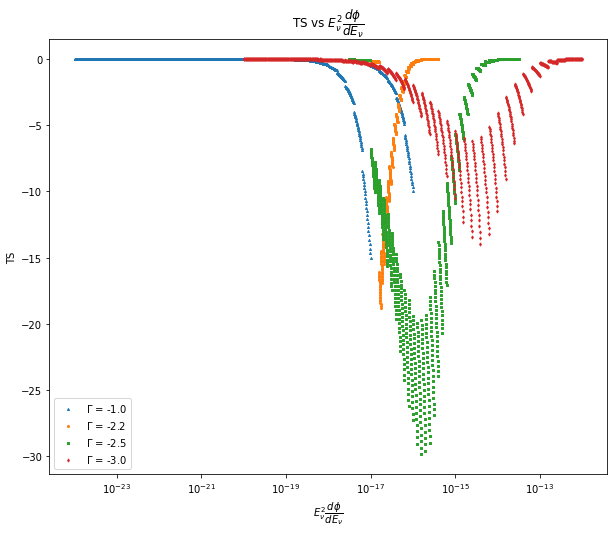

In [13]:
all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)
phi0 = 1e-40
e2dfde = [] 
for i in prange(4):
    temp = []
    for eng in range(1000):
        temp.append((all_enu[eng]**2) * dfde(all_enu[eng], gamma_arr[i], phi0m[i]))
    e2dfde.append(temp)

e2dfde = np.asarray(e2dfde)
mark = ['^', 'o', 's', 'd']
plt.figure(figsize=(10,8))
for i in [0, 1, 2, 3]:#range(4):
    plt.scatter(e2dfde[i], all_TSS[i], label='$\Gamma$ = ' + str(gamma_arr[i]), s=4 , marker= mark[i])

plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$E^2_{\u03BD} \dfrac{d\phi}{dE_{\u03BD}}$')
plt.ylabel('TS')
plt.title('TS vs $E^2_{\u03BD} \dfrac{d\phi}{dE_{\u03BD}}$')
#plt.xlim(1e-17, 1e-13)
#plt.ylim(-100, 10)
plt.show()

In [ ]:
import numba as nb

In [ ]:
@nb.njit
def find_index(vec_uptparts, i):
    idx = np.nanmin([idx if not val else vec_uptparts.size for idx, val in enumerate(vec_uptparts <= i)])
    return idx - 1

In [ ]:
for i in enumerate(vec_uptparts <= 23):
    print(i)

(0, True)
(1, False)
(2, False)
(3, False)
(4, False)
(5, False)


In [55]:
%timeit [temp(x) for x in range(1000)]

3.12 ms ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
%timeit [wall_nu(x) for x in range(1000)]       # for and if faster than other methods

110 µs ± 1.94 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [57]:
%timeit [find_index(vec_uptparts, x) for x in range(1000)]

349 µs ± 4.11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [59]:
%timeit [bisect.bisect_right(vec_uptparts, x) - 1 for x in range(1000)]

405 µs ± 4.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
ns_singleseason_sing_psr_HAT(0.5, 1e12, -2.2, phi0m[1], season=0)

In [66]:
%%time
psrns = 0
enu = 2
gamma = 1
for psrdec in prange(p):
    for season in range(10):    
        psrns += ns_singleseason_sing_psr_HAT(psrdec, all_enu[enu], gamma_arr[gamma], phi0m[gamma],season=season)

CPU times: user 302 ms, sys: 4.07 ms, total: 306 ms
Wall time: 305 ms


In [73]:
%%time
psrns = 4
enu = 2
gamma = 1
for psrdec in prange(p):
    for season in range(10):    
        psrns += ns_singleseason_sing_psr_HAT(psrdec, all_enu[enu], gamma_arr[gamma], phi0m[gamma],season=season)

CPU times: user 114 ms, sys: 62 µs, total: 114 ms
Wall time: 113 ms
